# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [3]:
df = pd.read_csv('bikes_rent.csv')

df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

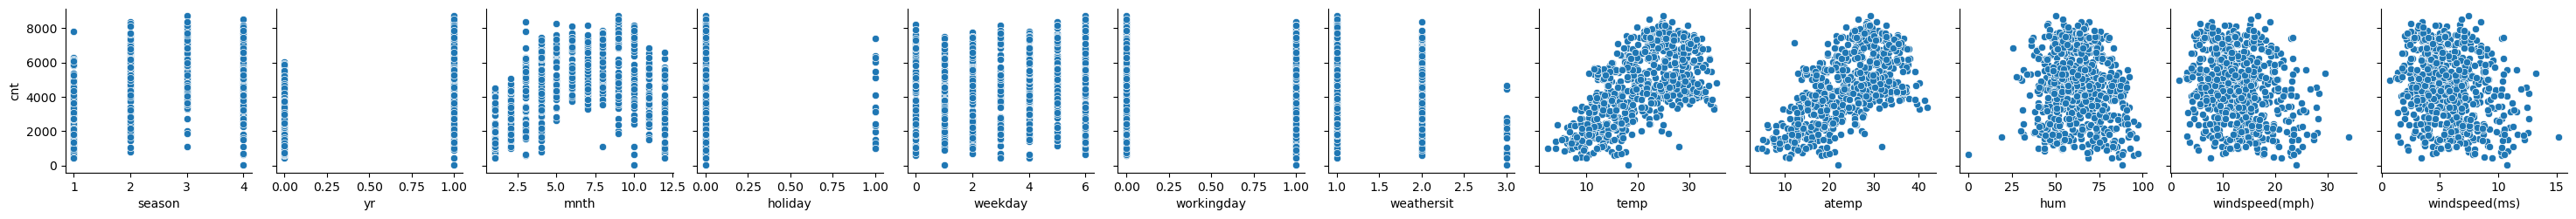

In [23]:
predictors = list(df.drop(['cnt'], axis=1).columns)
pairplots = sns.pairplot(data=df, x_vars=predictors, y_vars=['cnt'])
display(pairplots)

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

**Answears**

1. There is a positive dependency between the month and number of rentals. The number of rentals goes higher starting from the 5th month and subsides after 9th month. So people tend to rent more bikes during the warm time of the year.

2. ``temp`` and ``atemp`` show a linear relationship with the count of rentals.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    int64  
 2   mnth            731 non-null    int64  
 3   holiday         731 non-null    int64  
 4   weekday         731 non-null    int64  
 5   workingday      731 non-null    int64  
 6   weathersit      731 non-null    int64  
 7   temp            731 non-null    float64
 8   atemp           731 non-null    float64
 9   hum             731 non-null    float64
 10  windspeed(mph)  731 non-null    float64
 11  windspeed(ms)   731 non-null    float64
 12  cnt             731 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 74.4 KB


**We can see that we do not have any null-values and that all of the data types are numerical, which is good as regression does not support categorical non-encoded variables.**

In [26]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,20.310776,23.717699,62.789406,12.762576,5.705220,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,7.505091,8.148059,14.242910,5.192357,2.321125,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,0.670650,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.820424,16.892125,52.000000,9.041650,4.041864,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,20.431653,24.336650,62.666700,12.125325,5.420351,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.872076,30.430100,73.020850,15.625371,6.984967,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,15.198937,8714.000000


**Predictors display different scales, so it is a good idea to standardize them.**

**Also ``mnth`` has a high cardinality. One of the possible ways of dealing with it to avoid the curse of dimensionality would be grouping it by season, but we already have this variable, so it is not needed.**

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [28]:
df[predictors].corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


**We can see that ``mnth`` and ``season`` correlate a lot. Later we will see which of these two features has a bigger contribution to the ``cnt``.**

**Also ``temp`` and ``atemp`` have a high coefficient of correlation. So it is reasonable to drop one of these columns.**

**And two features that count the windspeed in two different metric systems are excessive.**

In [29]:
df[predictors].corrwith(df['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

**From this we can see that ``season`` makes a higher contribution to ``cnt`` than ``mnth``. And ``atemp`` has a higher correlation than ``temp``. So when choosing features for the model training it is reasonable to get rid of ``mnth``, ``temp``, and one of the windspeed metrics.**

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [30]:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [31]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

**As regression makes an assumption of normal distribution of data, we will also look at distribution plots and skewness metrics.**

-0.0545209647604073

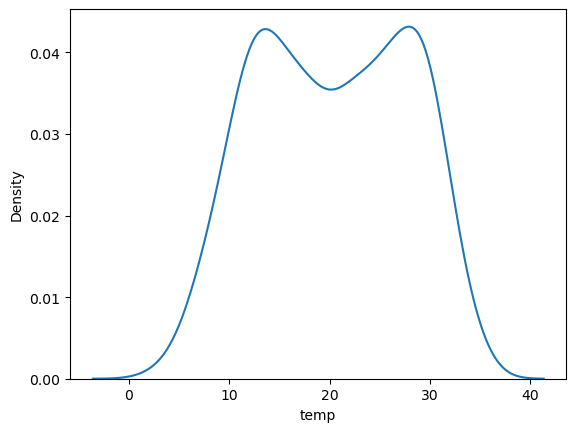

In [71]:
sns.kdeplot(data=df['temp'])
df['temp'].skew()

-0.13108804205446092

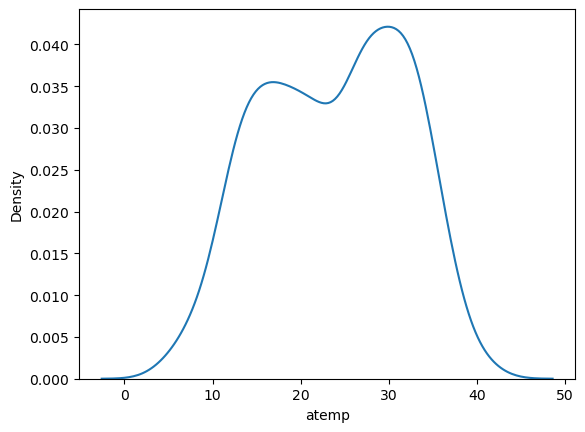

In [45]:
sns.kdeplot(data=df['atemp'])
df['atemp'].skew()

-0.06978343399094819

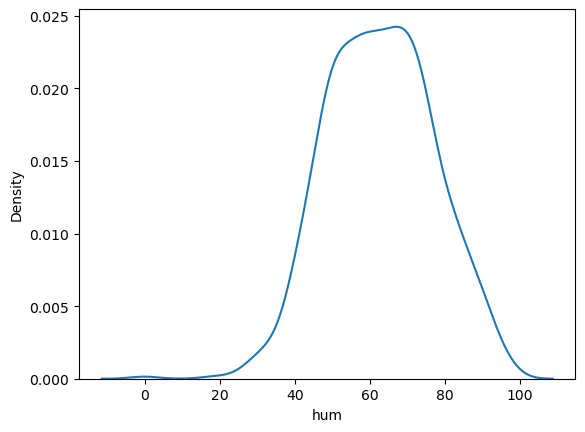

In [46]:
sns.kdeplot(data=df['hum'])
df['hum'].skew()

0.6773454211094491

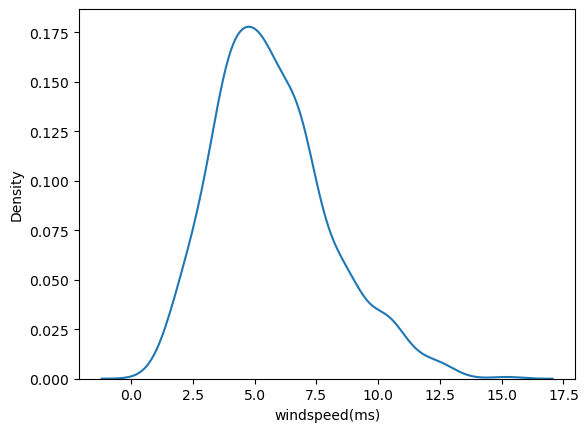

In [47]:
sns.kdeplot(df['windspeed(ms)'])
df['windspeed(ms)'].skew()

**Windspeed distribution has a moderate skewness.**

-0.04735278011900183

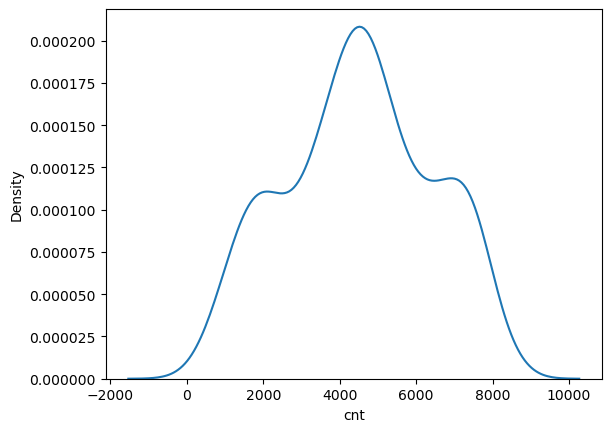

In [48]:
sns.kdeplot(df['cnt'])
df['cnt'].skew()

**The skewness of all the numerical features is within a reasonable range, so there is no need in any data transformations.**

**Let's check the dataset for outliers.**

In [53]:
from scipy.stats import zscore

In [56]:
df[['weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].apply(zscore).describe().round(3)

,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000,731.000,731.000,731.000,731.000,731.000,731.000
mean,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-0.726,-2.385,-2.427,-4.411,-2.171,-2.171,-2.315
25%,-0.726,-0.865,-0.838,-0.758,-0.717,-0.717,-0.699
50%,-0.726,0.016,0.076,-0.009,-0.123,-0.123,0.023
75%,1.110,0.875,0.824,0.719,0.552,0.552,0.750
max,2.947,2.002,2.251,2.421,4.093,4.093,2.175


**We can see that min value of ``hum`` is more than -3 stds from the mean, so it can be marked as an outlier. And max value of ``windspeed`` is 4 stds away from the mean.**

**Let's check humidity first.**

<Axes: >

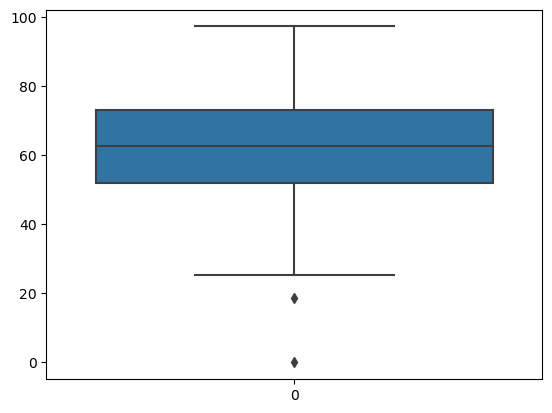

In [57]:
sns.boxplot(df['hum'])

<Axes: xlabel='hum', ylabel='cnt'>

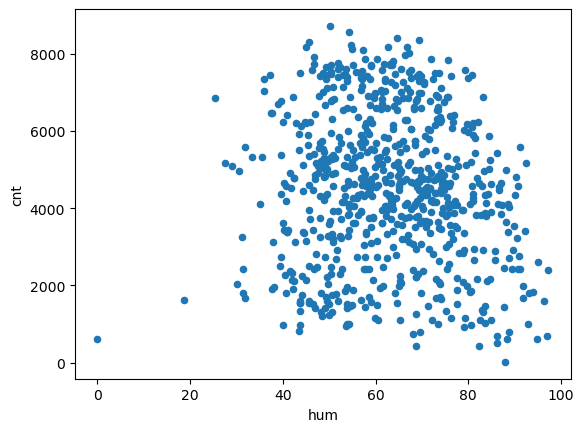

In [58]:
df.plot.scatter(x='hum', y='cnt')

**From a univariate analysis we can see that there are two points that are far away from the rest of the observations. But from a bi-variate analysis we cannot conclude that they do not comply with the trend so probably they are not levarage points. Let's look at this two observations to see if they are in any way weird.**

In [63]:
df.sort_values(by='hum')[:2]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
68,1,0,3,0,4,1,3,15.952731,19.2834,0.0000,17.545759,7.843433,623
49,1,0,2,0,6,0,1,16.365847,19.5702,18.7917,34.000021,15.198937,1635


**The first observation does ring a bell, because it has 0 humidity, while having a value of ``weathersit`` as 3 (though 1 is a clean sky and a good weather and 4 is a shower and a fog). From this scale we can conclude that 0 humidity cannot go together with a weathersit of 3. Especially when we see that the second observation has a ``weathersit`` of 1 and a higher humidity. Let's look at other observations with a value of ``weatehrsit`` of 3.**

In [66]:
df.loc[df['weathersit'] == 3]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
25,1,0,1,0,3,1,3,8.917500,10.18000,86.2500,19.687950,8.801051,506
68,1,0,3,0,4,1,3,15.952731,19.28340,0.0000,17.545759,7.843433,623
89,2,0,3,0,4,1,3,11.001653,12.87875,91.8333,14.582282,6.518678,1685
105,2,0,4,0,6,0,3,17.664153,21.27460,88.8333,22.834136,10.207481,795
248,3,0,9,0,2,1,3,22.140000,25.76000,88.6957,23.044181,10.301377,2710
249,3,0,9,0,3,1,3,24.565847,27.21145,91.7083,6.500394,2.905853,1996
250,3,0,9,0,4,1,3,25.990433,27.76805,93.9565,12.914116,5.772962,1842
284,4,0,10,0,3,1,3,22.276653,25.88585,90.6250,16.626050,7.432298,2416
291,4,0,10,0,3,1,3,22.211299,25.69240,89.5217,16.303713,7.288204,2424
301,4,0,10,0,6,0,3,10.420847,11.39565,88.2500,23.541857,10.523852,627


**We can see that for a value of ``weathersit`` of 3 we expect a humidity value between 73 and 97. So observation number 68 must be a mistake. If this value is a leverage or not we can check by training a model with and without this observation and see it anything changes.**

**Now let's check the windspeed.**

<Axes: >

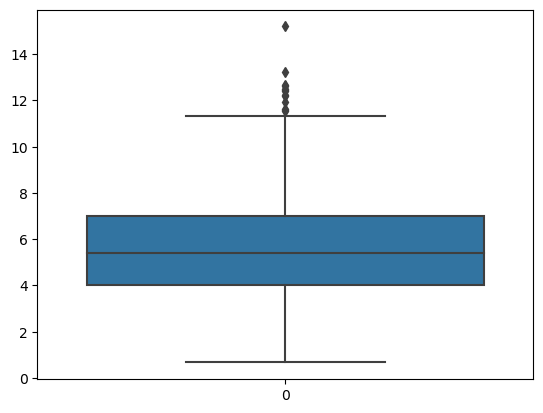

In [59]:
sns.boxplot(df['windspeed(ms)'])

<Axes: xlabel='windspeed(ms)', ylabel='cnt'>

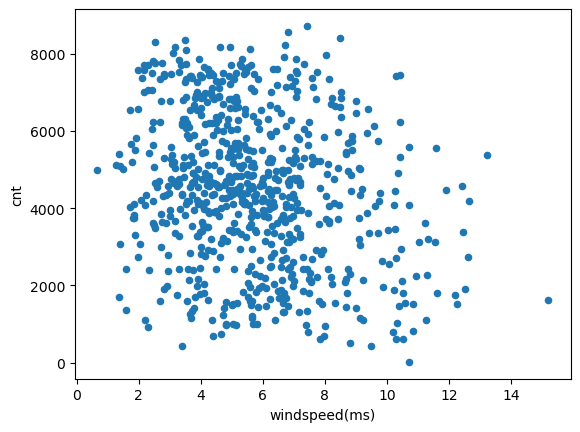

In [60]:
df.plot.scatter(x='windspeed(ms)', y='cnt')

**It has some number of outliers, which we can see on the univariate plot but they do not seem to break the trend. Only an observation which is higher than 14 is of interest.** 

In [70]:
df.sort_values(by='windspeed(ms)', ascending=False)[:11]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
49,1,0,2,0,6,0,1,16.365847,19.57020,18.7917,34.000021,15.198937,1635
432,1,1,3,0,4,1,1,21.627500,26.23020,56.7500,29.584721,13.225177,5382
292,4,0,10,0,4,1,1,19.509153,23.32625,63.6250,28.292425,12.647485,4195
420,1,1,2,0,6,0,1,11.924153,12.78375,39.5833,28.250014,12.628527,2732
44,1,0,2,0,1,1,1,17.015000,19.91750,37.5833,27.999836,12.516690,1913
382,1,1,1,0,3,1,1,12.436653,13.76270,44.3333,27.833743,12.442442,3376
433,1,1,3,0,5,1,2,16.844153,19.85415,40.7083,27.791600,12.423603,4569
407,1,1,2,0,0,0,1,5.227500,5.08290,46.4583,27.417204,12.256238,1529
721,1,1,12,0,6,0,1,10.899153,11.80565,44.1250,27.292182,12.200350,1749
666,4,1,10,0,0,0,2,19.577500,23.38855,69.4583,26.666536,11.920669,4459


**The windiest day does not differ much from the rest top-10 windy days so we will not do anything with this observation. The majority of them are in spring and in month 2 (supposedly it is April). The only thing that bothers me is that ``atemp`` values are higher than ``temp`` values for 9 out of 10 observations, which is counterintuitive (as higher windspeed usually makes the perception of temperature lower but not higher). That may indicate an error in data collection.**

In [73]:
len(df.loc[df['atemp'] > df['temp']])

729

In [74]:
len(df.loc[df['atemp'] < df['temp']])

2

**If we look at these statistics we will see that out of 731 observations only 2 have an apparent temperature lower than the real one which cannot be true as apparent temperature in nature correlates with the real temperature + level of humidity + speed of wind. Thus, days with high humidity and high windspeed have to have a value of apparent temperature lower than the real one. And if we examine these two observations we will see the second one has a 17 degrees difference between ``temp`` and ``atemp``, which must be a mistake.**

In [75]:
df.loc[df['atemp'] < df['temp']]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
407,1,1,2,0,0,0,1,5.227500,5.0829,46.4583,27.417204,12.256238,1529
594,3,1,8,0,5,1,1,29.656653,12.1200,57.0833,15.500718,6.929244,7148


### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [49]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [50]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [51]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [52]:
model = LinearRegression()
model.fit(X, y)

for predictor, weight in zip(df.columns, model.coef_):
    print(f'{predictor}: {weight}')

season: 570.8674889862766
yr: 1021.9645159780381
mnth: -141.30356420478935
holiday: -86.75926356396214
weekday: 137.22578660883255
workingday: 56.3913311383312
weathersit: -330.2297697024501
temp: 367.4787098469888
atemp: 585.5515377590608
hum: -145.61340408928012
windspeed(mph): 12456110242934.967
windspeed(ms): -12456110243133.432


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [77]:
from sklearn.linear_model import Lasso

In [78]:
l1_model = Lasso()
l1_model.fit(X, y)

for predictor, weight in zip(df.columns, l1_model.coef_):
    print(f'{predictor}: {weight}')

season: 560.2416160308857
yr: 1019.4634940657195
mnth: -128.73062703678693
holiday: -86.15278133371105
weekday: 137.34789390496329
workingday: 55.21237064135678
weathersit: -332.3698569623487
temp: 376.36323620969864
atemp: 576.530793504551
hum: -144.12915500348578
windspeed(mph): -197.1396894024843
windspeed(ms): -2.805139889577359e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [79]:
l2_model = Ridge()
l2_model.fit(X, y)

for predictor, weight in zip(df.columns, l2_model.coef_):
    print(f'{predictor}: {weight}')

season: 563.0645722520159
yr: 1018.948378787529
mnth: -131.87332028247553
holiday: -86.74609799709262
weekday: 138.00511117871886
workingday: 55.903110375064365
weathersit: -332.3497884990727
temp: 386.4578891919364
atemp: 566.3470470600394
hum: -145.0713272986727
windspeed(mph): -99.25944108185699
windspeed(ms): -99.25944115427635


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [89]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    l1_model = Lasso(alpha=alpha)
    l1_model.fit(X, y)
    coefs_lasso.append(l1_model.coef_)
    
    l2_model = Ridge(alpha=alpha)
    l2_model.fit(X, y)
    coefs_ridge.append(l2_model.coef_)

In [90]:
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

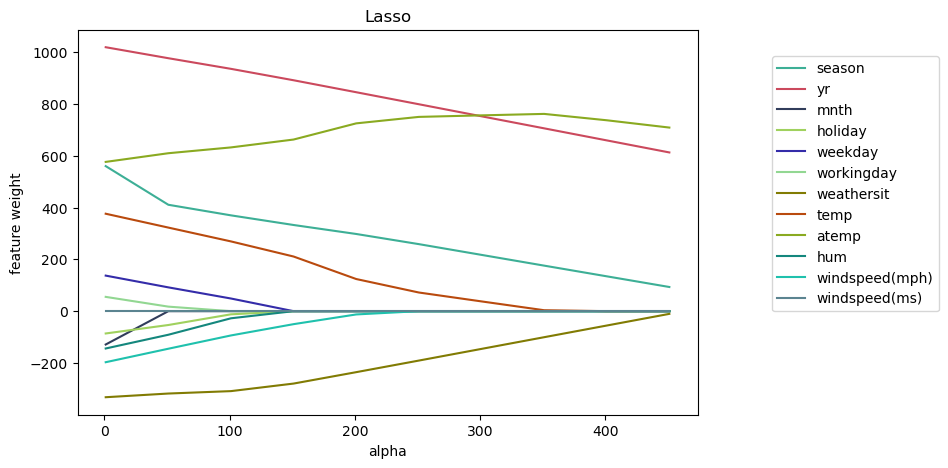

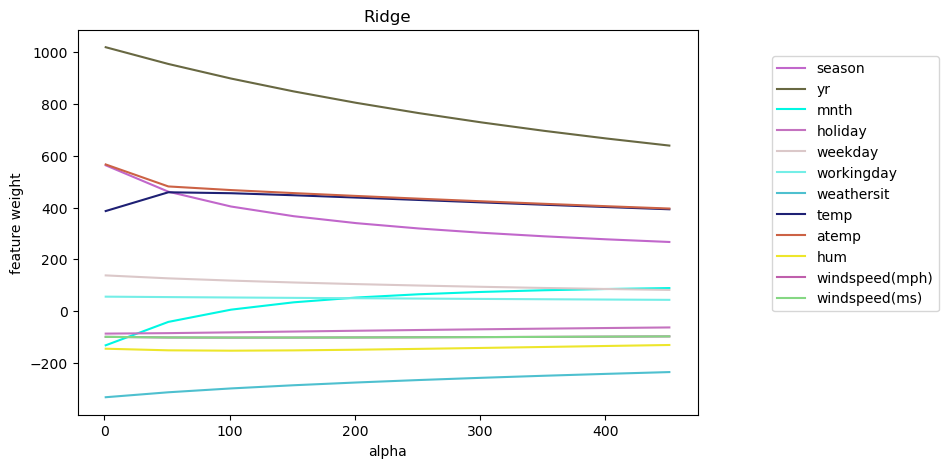

In [92]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

**Answears**

1. Lasso shrinks the weights more aggressively.
2. Lasso aims at minimizing the cost function for linear regression + alpha*weights. So if alpha is large, the way to minimize it's effect on the cost functions is to set weights to 0. Thus, all the weights will be zeroed and the model will have a high bias.
3. Yes for Lasso, no for Ridge.
4. Lasso regression is better for feature selection.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [121]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

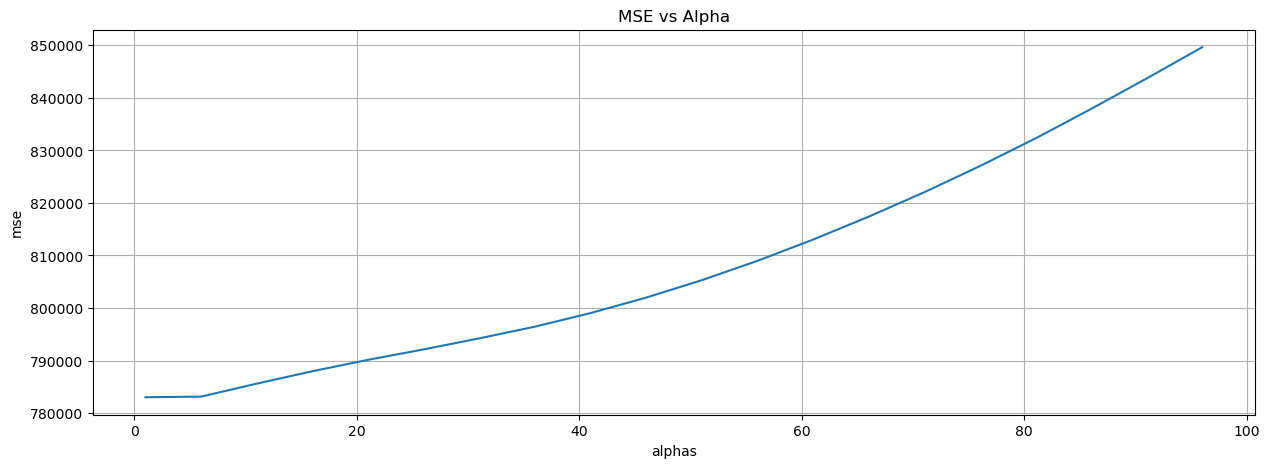

In [122]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas).fit(X, y)
mean_mse = [mse.mean() for mse in regressor.mse_path_]
data = list(zip(regressor.alphas_, mean_mse))
create_plot(data=data, title='MSE vs Alpha', xlabel='alphas', ylabel='mse')

In [123]:
print(f'Chosen alpha = {regressor.alpha_}')
for feature, weight in zip(df.columns, regressor.coef_):
    print(f'{feature}: {weight}')

Chosen alpha = 1
season: 560.2416160308857
yr: 1019.4634940657195
mnth: -128.73062703678693
holiday: -86.15278133371105
weekday: 137.34789390496329
workingday: 55.21237064135678
weathersit: -332.3698569623487
temp: 376.36323620969864
atemp: 576.530793504551
hum: -144.12915500348578
windspeed(mph): -197.1396894024843
windspeed(ms): -2.805139889577359e-08


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


In [124]:
for alpha, mse in enumerate(np.min(regressor.mse_path_, axis=0)):
    alpha_min = regressor.mse_path_[:, alpha].argmin(axis=0)
    print(f'Alpha = {regressor.alphas_[alpha_min]}, MSE = {mse}')

Alpha = 1, MSE = 691447.2507878069
Alpha = 11, MSE = 883471.18294254
Alpha = 1, MSE = 710110.1624117339
Alpha = 26, MSE = 860737.4059488717
Alpha = 21, MSE = 750676.3567789996


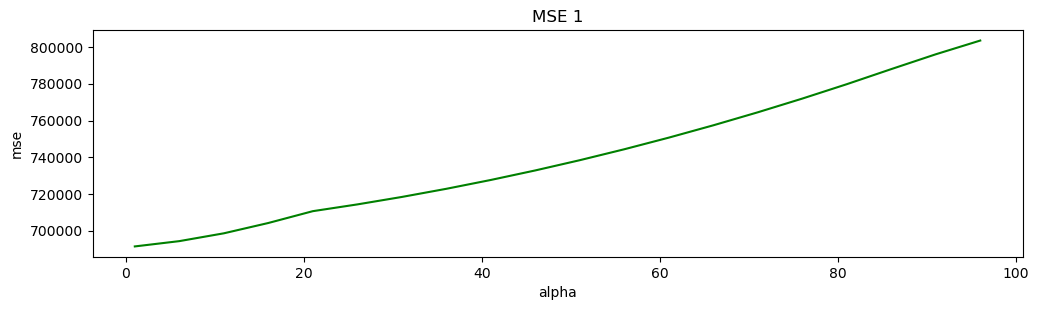

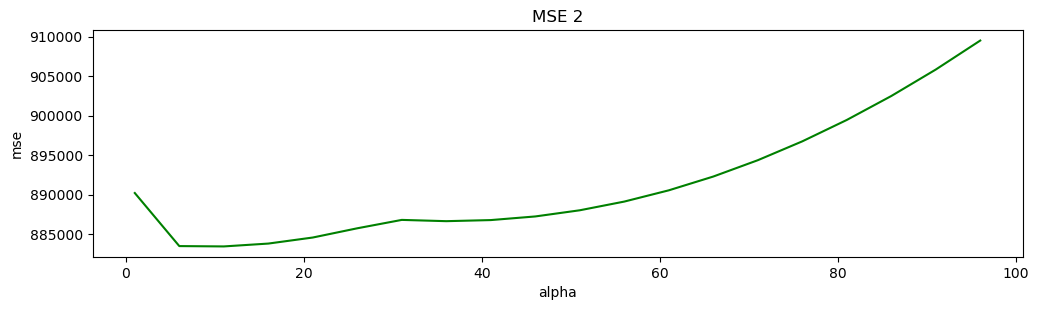

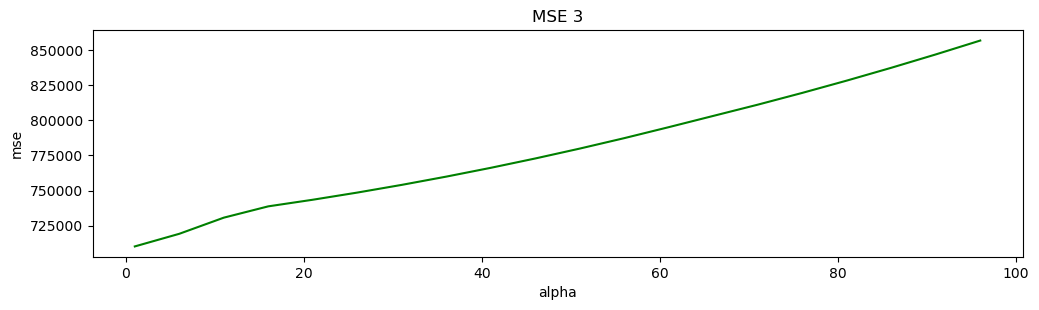

In [130]:
for i in range(3):
    plt.figure(figsize=(12, 10))
    plt.subplot(3, 1, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], c='g')
    plt.title(f'MSE {i+1}')
    plt.xlabel('alpha')
    plt.ylabel('mse')

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [139]:
features_weights = list(zip(df.columns, regressor.coef_))
features_weights.sort(key = lambda x: x[1], reverse=True)
print(features_weights[:4])

[('yr', 1019.4634940657195), ('atemp', 576.530793504551), ('season', 560.2416160308857), ('temp', 376.36323620969864)]


**Yes, on the bi-variate plots we can see linear relationships between these features but I have some doubts about the prognostic value of ``temp`` and ``atemp`` as they have a 0.99 coefficient of correlation between each other. So having both of these features together is a bad idea, because they do not contribute any new information to the model. So I would get rid of one of those (most certainly of ``atemp`` as I have already mentioned that there is a weird pattern between these 2 features, so I think that ``temp`` might be more correct). And it is strange that year got to be a predictor that has the highest weight in determining the number of rentals. There may be a steady growth in a number of rentals across years but this has to be proven on more historical data.**

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [143]:
features_weights = list(zip(df.columns, regressor.coef_))
features_weights.sort(key = lambda x: x[1])
print(features_weights[:3])

[('weathersit', -332.3698569623487), ('windspeed(mph)', -197.1396894024843), ('hum', -144.12915500348578)]


**Linear relationship between these features and ``cnt`` is not super-strong but it exists. Expecting that the number of rentals will subside in case of rise of these features is common sense and logical.**

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [155]:
features_weights = list(zip(df.columns, regressor.coef_))
features_weights.sort(key = lambda x: -(1e-3) < x[1] < (1e-3), reverse=True)
print(features_weights[:1])

[('windspeed(ms)', -2.805139889577359e-08)]


**This feature is redundant so the model got rid of it. It is just a linear transformation of ``windspeed(mph)``.**

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.